In [ ]:
import torch
import torchvision
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/My Drive/Histopathology data/test2classes.zip" "test2classes.zip"
#!cp "/content/drive/My Drive/Histopathology data/Xception2categoriesmodel.pth" "Xception2categoriesmodel.pth"

In [ ]:
!unzip -q test2classes.zip

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
with open('test2classes/files_list.txt', 'r') as fp:
    files = fp.read().splitlines()
classes_str = [file.split('/')[0] for file in files]
classes_str, classes = np.unique(classes_str, return_inverse=True)
print(classes_str)
test_files=files
test_classes = classes
print(len(test_files))
print(len(test_classes))

['NORM' 'TUM']
7200
7200


In [ ]:
from PIL import Image
import torch.utils.data as data
class Hist(data.Dataset):
    def __init__(self, root, files, classes, transforms=None):
        self.root = root
        self.files = files
        self.classes = classes
        self.transforms = transforms

    def __getitem__(self, item):
        image = Image.open(os.path.join(self.root, self.files[item])).convert(mode="RGB")
        class_ = self.classes[item]
        if self.transforms:
            image = self.transforms(image)
        return image, class_

    def __len__(self):
        return len(self.files)

In [ ]:
batch_size_train = 10 # 
batch_size_test = 100 #

# define how image transformed
image_transform = torchvision.transforms.Compose([
                               torchvision.transforms.Resize((224, 224)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#image datasets

test_dataset = Hist('test2classes/', test_files, test_classes, 
                        transforms=image_transform)
#data loaders

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size_test, 
                                          shuffle=True, num_workers=2)

Label: TUM


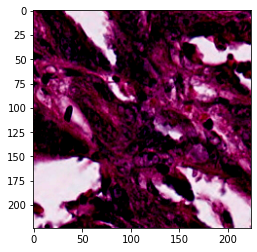

In [ ]:
# import library
import matplotlib.pyplot as plt
# We can check the dataloader
_, (example_datas, labels) = next(enumerate(test_loader))
sample = example_datas[0]
# show the data
plt.imshow(sample.permute(1, 2, 0));
print("Label: " + str(classes_str[labels[0]]))

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import math

class SeparableConvolution(nn.Module):
    def __init__(self, input_channel, output_channel, kernel_size=1, stride=1, padding=0, dilation=1, bias=False):
        super().__init__()
        self.dwc = nn.Sequential(
            nn.Conv2d(input_channel, input_channel, kernel_size, stride, padding, dilation, groups=input_channel, bias=bias),
            nn.Conv2d(input_channel, output_channel, 1, 1, 0, 1, 1, bias=bias)
        )
    
    def forward(self, X):
        return self.dwc(X)

class Block(nn.Module):
    def __init__(self, input_channel, out_channel, reps, strides=1, relu=True, grow_first=True):
        super().__init__()
        if out_channel != input_channel or strides!=1:
            self.skipConnections = nn.Sequential(
                nn.Conv2d(input_channel, out_channel, 1, stride=strides, bias=False),
                nn.BatchNorm2d(out_channel)
            )
        else:
            self.skipConnections = None
        self.relu = nn.ReLU(inplace=True)
        rep = []

        filters = input_channel
        if grow_first:
            rep.append(self.relu)
            rep.append(SeparableConvolution(input_channel, out_channel, 3, stride=1, padding=1, bias=False))
            rep.append(nn.BatchNorm2d(out_channel))
            filters = out_channel
        
        for _ in range(reps-1):
            rep.append(self.relu)
            rep.append(SeparableConvolution(filters, filters, 3, stride=1, padding=1, bias=False))
            rep.append(nn.BatchNorm2d(filters))
        
        if not grow_first:
            rep.append(self.relu)
            rep.append(SeparableConvolution(input_channel, out_channel, 3, stride=1, padding=1, bias=False))
            rep.append(nn.BatchNorm2d(out_channel))

        if not relu:
            rep = rep[1:]
        else:
            rep[0] = nn.ReLU(inplace=False)

        if strides != 1:
            rep.append(nn.MaxPool2d(3, strides, 1))

        self.rep = nn.Sequential(*rep)

    def forward(self, input):
        X = self.rep(input)

        if self.skipConnections:
            skip = self.skipConnections(input)
        else:
            skip = input
        
        X += skip
        return X

class Xception(nn.Module):
    def __init__(self, input_channel, n_classes):
        super().__init__()
        self.n_classes = n_classes
        self.relu = nn.ReLU(inplace=True)

        self.initBlock = nn.Sequential(
            nn.Conv2d(input_channel, 32, 3, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 64, kernel_size = 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.block1=Block(64,128,2,2,relu=False,grow_first=True)
        self.block2=Block(128,256,2,2,relu=True,grow_first=True)
        self.block3=Block(256,728,2,2,relu=True,grow_first=True)

        self.block4=Block(728,728,3,1,relu=True,grow_first=True)
        self.block5=Block(728,728,3,1,relu=True,grow_first=True)
        self.block6=Block(728,728,3,1,relu=True,grow_first=True)
        self.block7=Block(728,728,3,1,relu=True,grow_first=True)

        self.block8=Block(728,728,3,1,relu=True,grow_first=True)
        self.block9=Block(728,728,3,1,relu=True,grow_first=True)
        self.block10=Block(728,728,3,1,relu=True,grow_first=True)
        self.block11=Block(728,728,3,1,relu=True,grow_first=True)

        self.block12=Block(728,1024,2,2,relu=True,grow_first=False)

        self.convolution3 = SeparableConvolution(1024,1536,3,1,1)
        self.batchnorm3 = nn.BatchNorm2d(1536)

        #do relu here
        self.convolution4 = SeparableConvolution(1536,2048,3,1,1)
        self.batchnorm4 = nn.BatchNorm2d(2048)

        self.fc = nn.Linear(2048, self.n_classes)

        #weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x):
        x = self.initBlock(x)
        x = self.block1(x)
        
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.block9(x)
        x = self.block10(x)
        x = self.block11(x)
        x = self.block12(x)
        
        x = self.convolution3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        
        x = self.convolution4(x)
        x = self.batchnorm4(x)
        x = self.relu(x)

        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
import torch.nn.functional as F
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Xception(input_channel=3, n_classes=2)
model.load_state_dict(torch.load('Xception2SGD.pth', map_location=device))
model=model.to(device)

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import confusion_matrix
   
##define test function
def test(model, device, test_loader):
    # meters
    loss = AverageMeter()
    acc = AverageMeter()
    correct = 0
    # switch to test mode
    model.eval()
    y=[]
    y_pred=[]
    prob=[]
    for data, target in test_loader:
        t=target.tolist()
        y.append(t)
        data, target = data.to(device), target.to(device)  # data, target = data.cuda(), target.cuda()
        # since we dont need to backpropagate loss in testing,
        # we dont keep the gradient
        with torch.no_grad():
            # compute the forward pass
            # it can also be achieved by model.forward(data)
            output = model(data)
        p=output.tolist()
        prob.append(p)     
        # compute the loss function just for checking
        loss_this = F.cross_entropy(output, target) # sum up batch loss
        # get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True)
        m=pred.tolist()
        y_pred.append(m) 
        # check which are correct
        correct_this = pred.eq(target.view_as(pred)).sum().item()
        # accumulate the correct ones
        correct += correct_this
        # compute accuracy
        acc_this = correct_this/target.shape[0]*100.0
        # update the loss and accuracy meter 
        acc.update(acc_this, target.shape[0])
        loss.update(loss_this.item(), target.shape[0])
    print('Test: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss.avg, correct, len(test_loader.dataset), acc.avg))
    return loss.avg,acc.avg, y,y_pred,prob

In [ ]:
import os.path
from os import path



stl,acct,y,y_pred,prob=test(model, device, test_loader)

print('average accuracy: ',acct)

Test: Average loss: 0.0249, Accuracy: 7138/7200 (99.14%)

average accuracy:  99.13888888888889


In [ ]:
flat_prob=[element for sublist in prob for element in sublist]
proba=np.array(flat_prob)
flatten_y = [element for sublist in y for element in sublist]
flatten_y_pred = [element for sublist in y_pred for element in sublist]
flatten_y_pred = [element for sublist in flatten_y_pred for element in sublist]

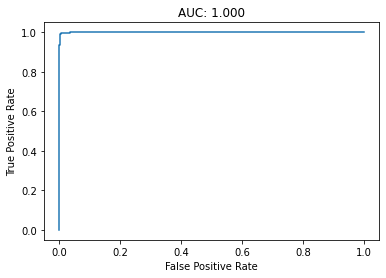

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
y_pred_proba = proba[::,1]
fpr, tpr, thresholds = roc_curve(flatten_y, y_pred_proba)
auc = roc_auc_score(flatten_y, y_pred_proba)
#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('AUC: %.3f' % auc)
plt.show()

In [ ]:
fpr=str(fpr)
tpr=str(tpr)

output_file = open('xception_fpr.txt', 'w')

for t in fpr:
    output_file.write(t)

output_file.close()


output_file = open('xception_tpr.txt', 'w')

for t in tpr:
    output_file.write(t)

output_file.close()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision=precision_score(flatten_y, flatten_y_pred)
precision=precision*100
print(precision)

98.36474501108647


In [ ]:
recall=recall_score(flatten_y, flatten_y_pred)
recall=recall*100
print(recall)

98.58333333333333


In [ ]:
f1=f1_score(flatten_y, flatten_y_pred)
f1=f1*100
print(f1)

98.47391786903441
